In [1]:
import numpy as np
import matplotlib.pyplot as plt
import setigen as stg
from astropy import units as u
import gc
from numba import njit, prange
from concurrent.futures import ProcessPoolExecutor

In [2]:
%matplotlib inline

In [106]:
data_shape = np.load('Data/HIP13402/shape.npy')
data_shape = tuple(int(dim) for dim in data_shape)
data = np.memmap('Data/HIP13402/seperated_raw_data.npy', dtype='float32', mode='r', shape=data_shape)

In [107]:
print(data[0])

[[[2.9737974e+08 3.2028000e+08 3.0362010e+08 ... 2.9946086e+08
   3.2718822e+08 2.7946435e+08]
  [2.5460648e+08 2.8272547e+08 2.9888973e+08 ... 2.6859581e+08
   2.8414214e+08 2.7613376e+08]
  [3.0044432e+08 2.2307587e+08 2.5267971e+08 ... 2.6419120e+08
   2.7568602e+08 2.8964707e+08]
  ...
  [3.3266995e+08 2.8726912e+08 2.7200928e+08 ... 3.4899283e+08
   3.0554701e+08 2.7303907e+08]
  [2.6879920e+08 2.8195101e+08 2.9565376e+08 ... 2.8785136e+08
   2.8035069e+08 2.8888800e+08]
  [2.8728621e+08 2.8424013e+08 2.8181562e+08 ... 2.9164854e+08
   2.6896890e+08 3.6296074e+08]]

 [[2.9248528e+08 2.7308544e+08 3.0395229e+08 ... 2.6141981e+08
   3.1028470e+08 2.5517131e+08]
  [2.8441613e+08 2.8950326e+08 2.5309843e+08 ... 2.9618851e+08
   2.8762019e+08 2.5206470e+08]
  [2.4620242e+08 2.9434819e+08 3.0132909e+08 ... 2.8049344e+08
   2.8623357e+08 3.0429315e+08]
  ...
  [2.8814358e+08 2.4986566e+08 2.8908390e+08 ... 3.0320621e+08
   3.2463923e+08 2.6274678e+08]
  [3.0033613e+08 2.8985936e+08 2.999

In [5]:
test_data = data[0:10000]

In [6]:
test_data[0].shape

(6, 16, 4096)

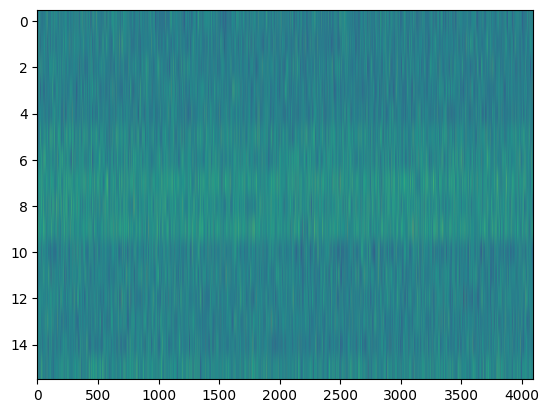

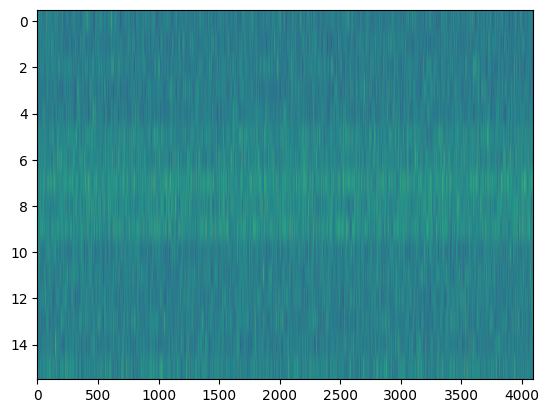

In [7]:
plt.imshow(test_data[0,0],aspect= 'auto')
plt.show()

plt.imshow(test_data[1,0],aspect= 'auto')
plt.show()

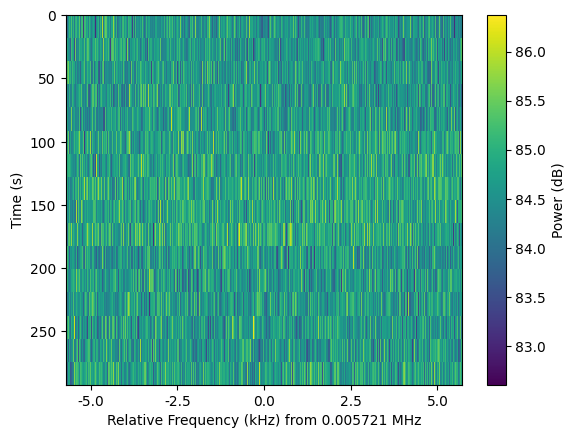

In [8]:
frame = stg.Frame.from_data(df=2.7939677238464355*u.Hz,
                        dt=18.25361108*u.s,
                        fch1=0*u.MHz,
                        ascending = True,
                        data=test_data[0,0])

frame.plot()
plt.show()

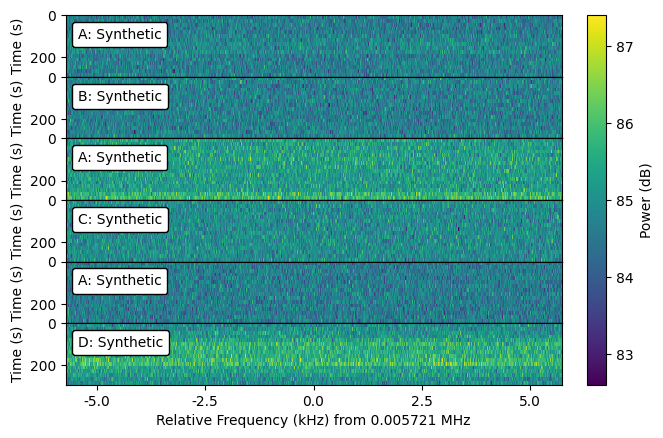

In [9]:
c = stg.Cadence()
frame_list = []
for i in range(6):
    frame = stg.Frame.from_data(df=2.7939677238464355*u.Hz,
                            dt=18.25361108*u.s,
                            fch1=0*u.MHz,
                            ascending = True,
                            data=test_data[0,i])
    frame_list.append(frame)
    # del frame
    # gc.collect()



c = stg.OrderedCadence(frame_list, order = "ABACAD")
c.plot()
plt.show()

(array([<Axes: ylabel='Time (s)'>, <Axes: >, <Axes: ylabel='Time (s)'>,
        <Axes: >, <Axes: ylabel='Time (s)'>, <Axes: >,
        <Axes: ylabel='Time (s)'>, <Axes: >, <Axes: ylabel='Time (s)'>,
        <Axes: >,
        <Axes: xlabel='Relative Frequency (kHz) from 0.005721 MHz', ylabel='Time (s)'>],
       dtype=object),
 <Axes: ylabel='Power (dB)'>)

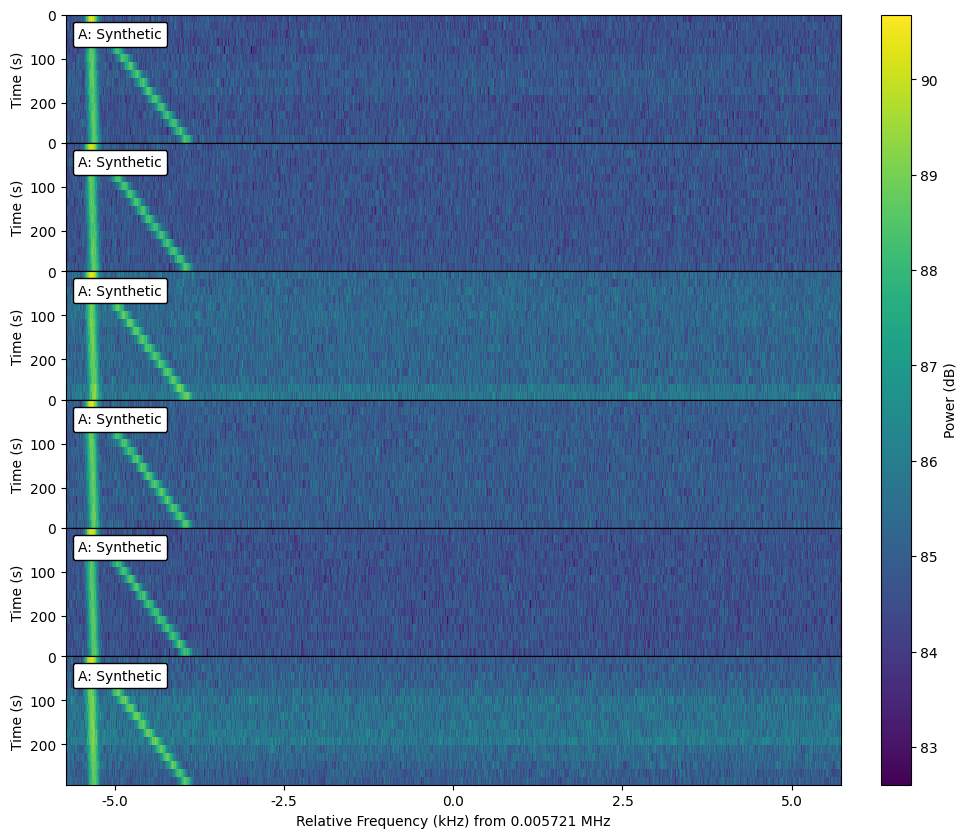

In [108]:
c.by_label("A").add_signal(stg.constant_path(f_start=c[0].get_frequency(index=128),
                               drift_rate=5*u.Hz/u.s),
                           stg.constant_t_profile(level=c[0].get_intensity(snr=60)),
                           stg.sinc2_f_profile(width=100*c[0].df*u.Hz),
                           stg.constant_bp_profile(level=1),
                           doppler_smearing=True)
fig = plt.figure(figsize=(10, 10))
c.plot()

In [11]:
def process_cadence(data_slice):
    """
    Process a single cadence of data and generate an OrderedCadence.

    Parameters:
    - data_slice: A 2D numpy array (n_frames, frame_data) for one cadence.

    Returns:
    - OrderedCadence object.
    """
    frame_list = []
    for j in range(data_slice.shape[0]):  # Loop over frames in the cadence
        frame = stg.Frame.from_data(
            df=2.7939677238464355 * u.Hz,
            dt=18.25361108 * u.s,
            fch1=0 * u.MHz,
            ascending=True,
            data=data_slice[j]
        )
        frame_list.append(frame)

    # Create an OrderedCadence for this set of frames
    return stg.OrderedCadence(frame_list, order="ABACAD")


In [12]:
def generate_frames(data, max_workers=4):
    """
    Generate frames and cadences in parallel using ProcessPoolExecutor.

    Parameters:
    - data: 3D numpy array with shape (n_cadences, n_frames, frame_data)
    - max_workers: Number of parallel processes to use.

    Returns:
    - List of OrderedCadence objects.
    """
    cadences = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        cadences = list(executor.map(process_cadence, data))

    return cadences

In [13]:
for i in np.round(np.linspace(1,32,8)):
    print(i)

1.0
5.0
10.0
14.0
19.0
23.0
28.0
32.0


In [14]:
import time 
times = []
test_times = [26, 24, 16, 8, 1]

print(test_times)
for i in test_times:
    start = time.time()
    cadences = generate_frames(test_data, max_workers=i)
    end = time.time()
    times.append(end-start)
    print(f"Time taken: {end - start:.2f} seconds")



[26, 24, 16, 8, 1]
Time taken: 29.92 seconds
Time taken: 35.33 seconds
Time taken: 48.98 seconds
Time taken: 58.45 seconds
Time taken: 325.50 seconds


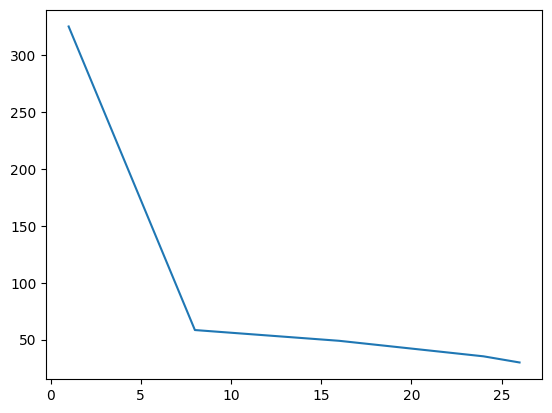

In [15]:
plt.plot(test_times, times)
plt.show()

In [21]:
dave = np.array(cadences)

In [22]:
dave.shape

(10000, 6)

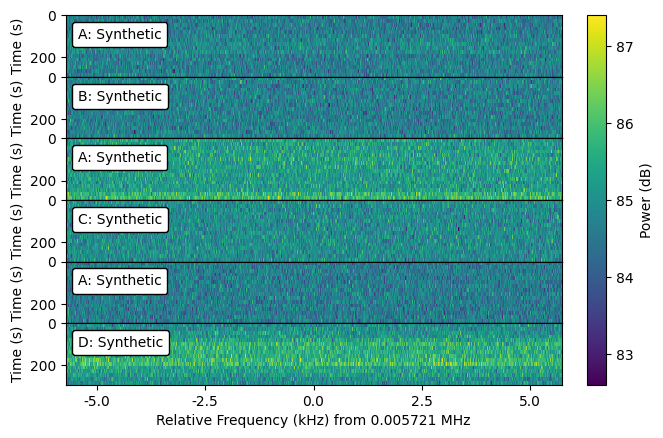

In [24]:
c2 = stg.Cadence()
frame_list2 = np.empty(6, dtype=object)
for i in range(6):
    frame = stg.Frame.from_data(df=2.7939677238464355*u.Hz,
                            dt=18.25361108*u.s,
                            fch1=0*u.MHz,
                            ascending = True,
                            data=test_data[0,i])
    frame_list2[i] = frame
    # del frame
    # gc.collect()



c2 = stg.OrderedCadence(frame_list2, order = "ABACAD")
c2.plot()
plt.show()

In [111]:
c2[0].add_signal(stg.constant_path(f_start=c2[0].get_frequency(index=128),
                                 drift_rate=5*u.Hz/u.s),
                            stg.constant_t_profile(level=c2[0].get_intensity(snr=60)),
                            stg.sinc2_f_profile(width=100*c2[0].df*u.Hz),
                            stg.constant_bp_profile(level=1),
                            doppler_smearing=True)
fig = plt.figure(figsize=(10, 10))
plt.show()

<Figure size 1000x1000 with 0 Axes>

In [78]:
help(c.by_label)

Help on method by_label in module setigen.cadence:

by_label(order_label='A') method of setigen.cadence.OrderedCadence instance
    Filter frames in cadence by their label in the cadence order, specified
    as a letter. Returns matching frames as a new Cadence.



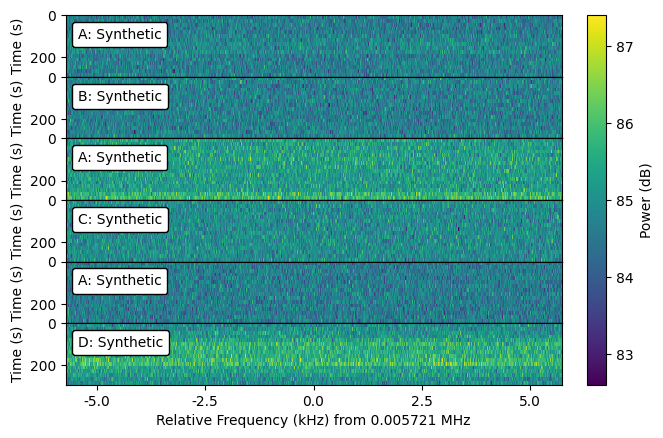

In [109]:
c = stg.Cadence()
frame_list = []
for i in range(6):
    frame = stg.Frame.from_data(df=2.7939677238464355*u.Hz,
                            dt=18.25361108*u.s,
                            fch1=0*u.MHz,
                            ascending = True,
                            data=test_data[0,i])
    frame_list.append(frame)
    # del frame
    # gc.collect()



c = stg.OrderedCadence(frame_list, order = "ABACAD")
c.plot()
plt.show()

(array([<Axes: ylabel='Time (s)'>, <Axes: >, <Axes: ylabel='Time (s)'>,
        <Axes: >, <Axes: ylabel='Time (s)'>, <Axes: >,
        <Axes: ylabel='Time (s)'>, <Axes: >, <Axes: ylabel='Time (s)'>,
        <Axes: >,
        <Axes: xlabel='Relative Frequency (kHz) from 0.005721 MHz', ylabel='Time (s)'>],
       dtype=object),
 <Axes: ylabel='Power (dB)'>)

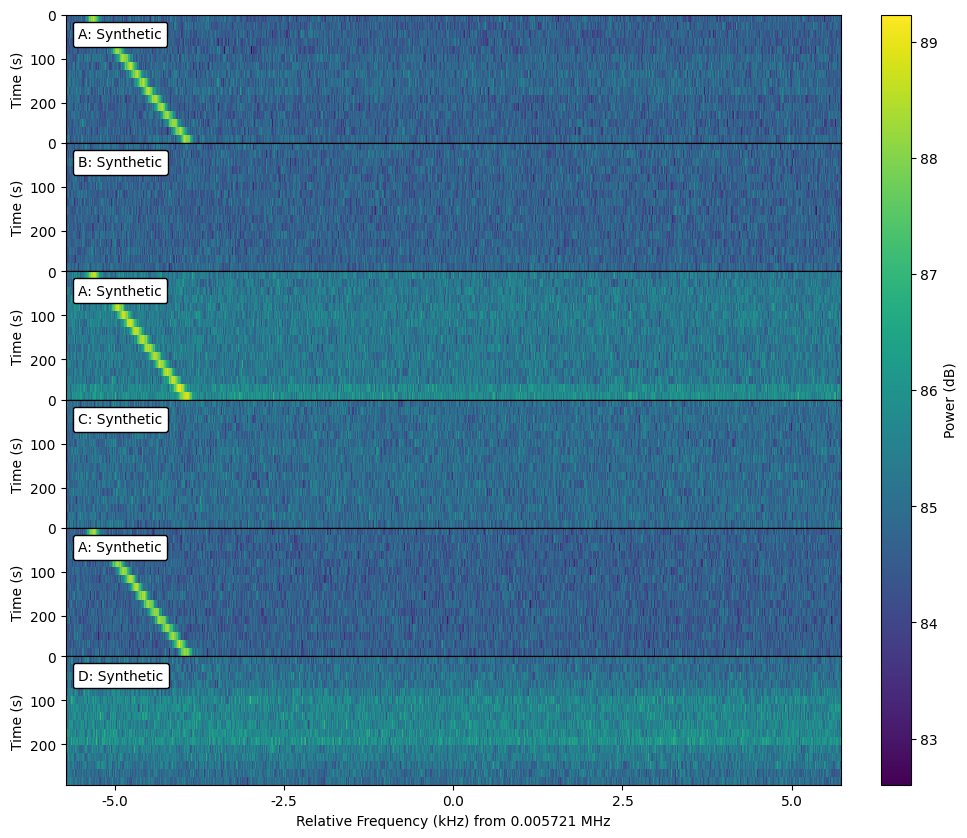

In [110]:
c.by_label("A").add_signal(stg.constant_path(f_start=c[0].get_frequency(index=128),
                               drift_rate=5*u.Hz/u.s),
                           stg.constant_t_profile(level=c[0].get_intensity(snr=60)),
                           stg.sinc2_f_profile(width=100*c[0].df*u.Hz),
                           stg.constant_bp_profile(level=1),
                           doppler_smearing=True)
fig = plt.figure(figsize=(10, 10))
c.plot()

In [81]:
test = np.array([frame.get_data() for frame in c])

In [82]:
test.shape

(6, 16, 4096)

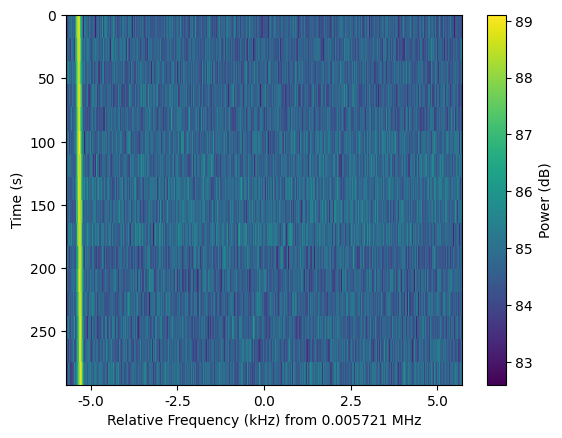

In [83]:
c[0].plot()

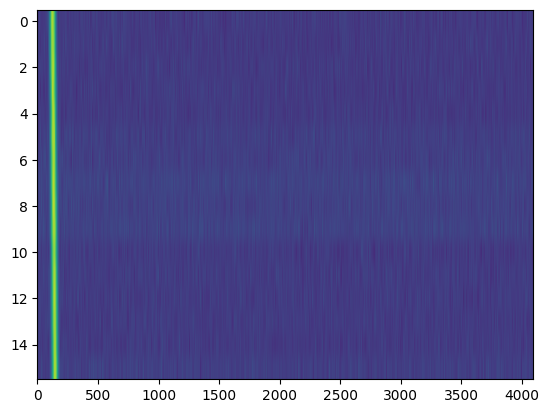

In [84]:
plt.imshow(test[0], aspect='auto')

In [85]:
test.shape

(6, 16, 4096)

In [86]:
test[0].shape

(16, 4096)

In [87]:
entry = np.log(test[4])

In [88]:
np.max(entry)

np.float32(20.506222)

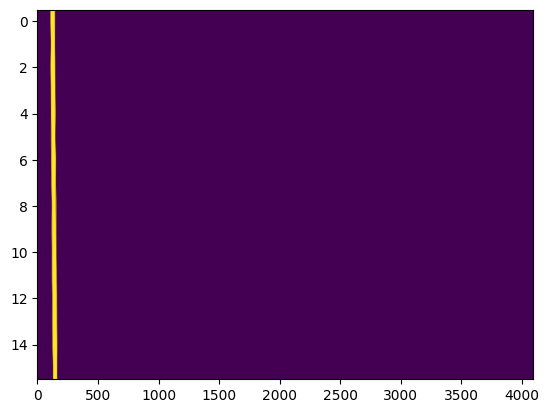

time taken: 0.00 seconds
altered_entry max = 1.0, altered_entry min = 0.0, altered_entry mean = 0.008880615234375, altered_entry std = 0.09381764382123947


In [89]:
count = 0
start_time = time.time()
entry = np.log(test[0])
altered_entry = np.copy(entry)
for i in range(entry.shape[0]):
    mean = np.mean(entry[i])
    std = np.std(entry[i])

    np.where(test[1][i] > mean + 0*std)
    altered_entry[i][np.where(entry[i] > mean + 5*std)] = 1
    altered_entry[i][np.where(entry[i] <= mean + 5*std)] = 0
    # count +=1
end_time = time.time()
plt.imshow(altered_entry, aspect='auto')
plt.show()
print(f"time taken: {end_time - start_time:.2f} seconds")
print(f"altered_entry max = {np.max(altered_entry)}, altered_entry min = {np.min(altered_entry)}, altered_entry mean = {np.mean(altered_entry)}, altered_entry std = {np.std(altered_entry)}")

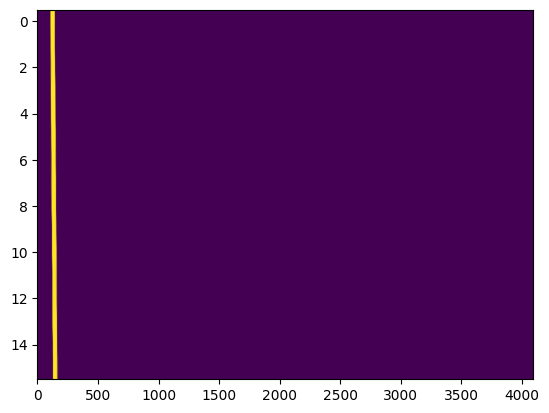

time taken: 0.00 seconds
altered_entry max = 1, altered_entry min = 0, altered_entry mean = 0.0089111328125, altered_entry std = 0.09397725535733625


In [90]:
import numpy as np
import matplotlib.pyplot as plt
import time


# Compute the mean and standard deviation along the first axis (rows)
start_time = time.time()
entry = np.log(test[4])
mean = np.mean(entry, axis=1, keepdims=True)
std = np.std(entry, axis=1, keepdims=True)

# Create a mask based on the condition
mask = entry > mean + 5 * std

# Apply the mask to create the altered entry
altered_entry = np.where(mask, 1, 0)
end_time = time.time()
# Visualize the result
plt.imshow(altered_entry, aspect='auto')
plt.show()
print(f"time taken: {end_time - start_time:.2f} seconds")
print(f"altered_entry max = {np.max(altered_entry)}, altered_entry min = {np.min(altered_entry)}, altered_entry mean = {np.mean(altered_entry)}, altered_entry std = {np.std(altered_entry)}")

In [91]:
0.09397725535733625-0.09397725760936737

-2.2520311171447815e-09

In [92]:
test.shape

(6, 16, 4096)

In [98]:
import numpy as np
import matplotlib.pyplot as plt
altered_entry = []
# Compute the mean and standard deviation along the first axis (rows)
for i in range(len(test)):
    entry = np.log(test[i])
    mean = np.mean(entry, axis=1, keepdims=True)
    std = np.std(entry, axis=1, keepdims=True)

    # Create a mask based on the condition
    mask = entry > mean + 5 * std

    # Apply the mask to create the altered entry
    altered_entry.append(np.where(mask, 1, 0))

    # Visualize the result
    # plt.imshow(altered_entry[i], aspect='auto')
    # plt.show()

for i in range(len(altered_entry)):
    print(f"mean = {np.mean(altered_entry[i])}, std = {np.std(altered_entry[i])}")

mean = 0.008880615234375, std = 0.0938176417707991
mean = 0.00897216796875, std = 0.09429564237381564
mean = 0.007843017578125, std = 0.08821283723695901
mean = 0.0083770751953125, std = 0.09114219553250064
mean = 0.0089111328125, std = 0.09397725535733625
mean = 0.0080108642578125, std = 0.0891442107579365


In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the log of test over all entries
log_test = np.log(test)  # Shape: (6, height, width)

# Compute mean and standard deviation along the second axis (rows)
mean = np.mean(log_test, axis=2, keepdims=True)  # Shape: (6, height, 1)
std = np.std(log_test, axis=2, keepdims=True)    # Shape: (6, height, 1)

# Create a mask for all entries in test
mask = log_test > mean + 5 * std  # Shape: (6, height, width)

# Apply the mask to create the altered entry for all
altered_entry2 = np.where(mask, 1, 0)  # Shape: (6, height, width)

# # Visualize each entry in test
# for i in range(altered_test.shape[0]):
#     plt.imshow(altered_test[i], aspect='auto')
#     plt.title(f"Altered Entry {i}")
#     plt.show()

for i in range(len(altered_entry2)):
    print(f"difference in mean = {np.mean(altered_entry2[i]) - np.mean(altered_entry[i])}, difference in  std = {np.std(altered_entry2[i])- np.std(altered_entry[i])}")

difference in mean = 0.0, difference in  std = 0.0
difference in mean = 0.0, difference in  std = 0.0
difference in mean = 0.0, difference in  std = 0.0
difference in mean = 0.0, difference in  std = 0.0
difference in mean = 0.0, difference in  std = 0.0
difference in mean = 0.0, difference in  std = 0.0
